# 

# Intro to Scikit-Learn

From: [Kaggle Temperature-Salinity + Geodata](https://www.kaggle.com/code/angelosorge/temperature-salinity-geodata)

## Regression

### Context

The CalCOFI data set represents the world’s longest (1949-present) and most complete (more than 50,000 sampling stations) oceanographic and larval fish data time series. The physical, chemical, and biological data collected at regular time and space intervals help document climatic cycles in the California Current and a range of biological responses to them. CalCOFI research drew world attention to the biological response to the dramatic Pacific warming event in 1957-58 and introduced the term “El Niño” into the scientific literature.

CalCOFI conducts quarterly cruises off southern and central California, collecting a suite of hydrographic and biological data on the station and underway. Data collected at depths down to 500 m include temperature, salinity, oxygen, phosphate, silicate, nitrate and nitrite, chlorophyll, transmissometer, PAR, C14 primary productivity, phytoplankton biodiversity, zooplankton biomass, and zooplankton biodiversity.

### Scope

We would like to know how we could predict the temperature of the water based on the salinity and the depth, as well as possibly other available features.

In [6]:
import platform
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import seaborn as sns
import sklearn
from sklearn import datasets, decomposition, metrics, preprocessing, utils
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from tqdm.notebook import tqdm

### Data

[Main Website: CalCOFI](https://calcofi.com/)

[Bottle-Dataset](https://new.data.calcofi.com/index.php/database/calcofi-database/bottle-field-descriptions)

[Cast-Dataset](https://new.data.calcofi.com/index.php/database/calcofi-database/cast-table-column-descriptions)

In [7]:
%config InlineBackend.figure_format="retina"  # For high DPI display

sns.set_style("darkgrid")
sns.set_context("notebook")

plotly.offline.init_notebook_mode(connected=True)

tqdm.pandas()

print(sklearn.__version__)  # Version tested on sklearn.__version__ == 1.5.x

1.5.2


### Utility Functions

In [8]:
def pprint_var(**kwargs):
    for k, v in kwargs.items():
        print(f"{k} = {v:.4g}")

#### Data loading

In [9]:
DATA = Path("./data")    # Change to your data folder
assert DATA.exists()

In [10]:
bottle_raw_df = pd.read_csv(DATA / "bottle.csv", low_memory=False)

In [11]:
bottle_info_df = pd.read_csv(
    DATA / "Bottle Field Descriptions.csv",
    encoding="cp1252",
).drop(columns=["Unnamed: 3"])

In [12]:
bottle_info_df[bottle_info_df["Field Name"] == "STheta"]

,Field Name,Units,Description
8,STheta,kilograms per cubic meter,"Potential Density (Sigma Theta), Kg/M³"


In [13]:
bottle_info_df

,Field Name,Units,Description
0,Cst_Cnt,n.a.,"Cast Count - All CalCOFI casts ever conducted,..."
1,Btl_Cnt,n.a.,Bottle Count - All CalCOFI bottles ever sample...
2,Sta_ID,n.a.,Line and Station [Line] [Station]
3,Depth_ID,n.a.,Uses the Cast_ID prefix ([Century]-[Year][Mont...
4,Depthm,meters,Bottle depth in meters
...,...,...,...
57,TA1,micromoles per kilogram,Total Alkalinity micromoles per kilogram solution
58,TA2,micromoles per kilogram,Total Alkalinity micromoles per kilogram solut...
59,pH1,pH scale,pH (the degree of acidity/alkalinity of a solu...
60,pH2,pH scale,pH (the degree of acidity/alkalinity of a solu...


In [14]:
bottle_df = bottle_raw_df.iloc[:, [0, 4, 5, 6, 7, 8]].copy()
del bottle_raw_df
bottle_df

,Cst_Cnt,Depthm,T_degC,Salnty,O2ml_L,STheta
0,1,0,10.500,33.4400,NaN,25.64900
1,1,8,10.460,33.4400,NaN,25.65600
2,1,10,10.460,33.4370,NaN,25.65400
3,1,19,10.450,33.4200,NaN,25.64300
4,1,20,10.450,33.4210,NaN,25.64300
...,...,...,...,...,...,...
864858,34404,0,18.744,33.4083,5.805,23.87055
864859,34404,2,18.744,33.4083,5.805,23.87072
864860,34404,5,18.692,33.4150,5.796,23.88911
864861,34404,10,18.161,33.4062,5.816,24.01426


In [15]:
bottle_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 864863 entries, 0 to 864862
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   Cst_Cnt  864863 non-null  int64  
 1   Depthm   864863 non-null  int64  
 2   T_degC   853900 non-null  float64
 3   Salnty   817509 non-null  float64
 4   O2ml_L   696201 non-null  float64
 5   STheta   812174 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 39.6 MB


#### Cleaning

Remove the NaN values

<span style="color:red">Implement your solution below</span>

In [16]:
bottle_df = bottle_df.dropna()
bottle_df.reset_index(drop=True, inplace=True)
bottle_df

,Cst_Cnt,Depthm,T_degC,Salnty,O2ml_L,STheta
0,71,0,10.300,33.0300,5.900,25.36400
1,71,6,18.460,32.9200,6.020,23.56800
2,71,10,10.290,32.9510,6.040,25.30400
3,71,15,10.290,32.9900,6.060,25.33500
4,71,20,10.330,33.0050,6.040,25.33900
...,...,...,...,...,...,...
661263,34404,0,18.744,33.4083,5.805,23.87055
661264,34404,2,18.744,33.4083,5.805,23.87072
661265,34404,5,18.692,33.4150,5.796,23.88911
661266,34404,10,18.161,33.4062,5.816,24.01426


### Data Analysis

#### Plot Correlation Matrix with Seaborn

<span style="color:red">Implement your solution below</span>

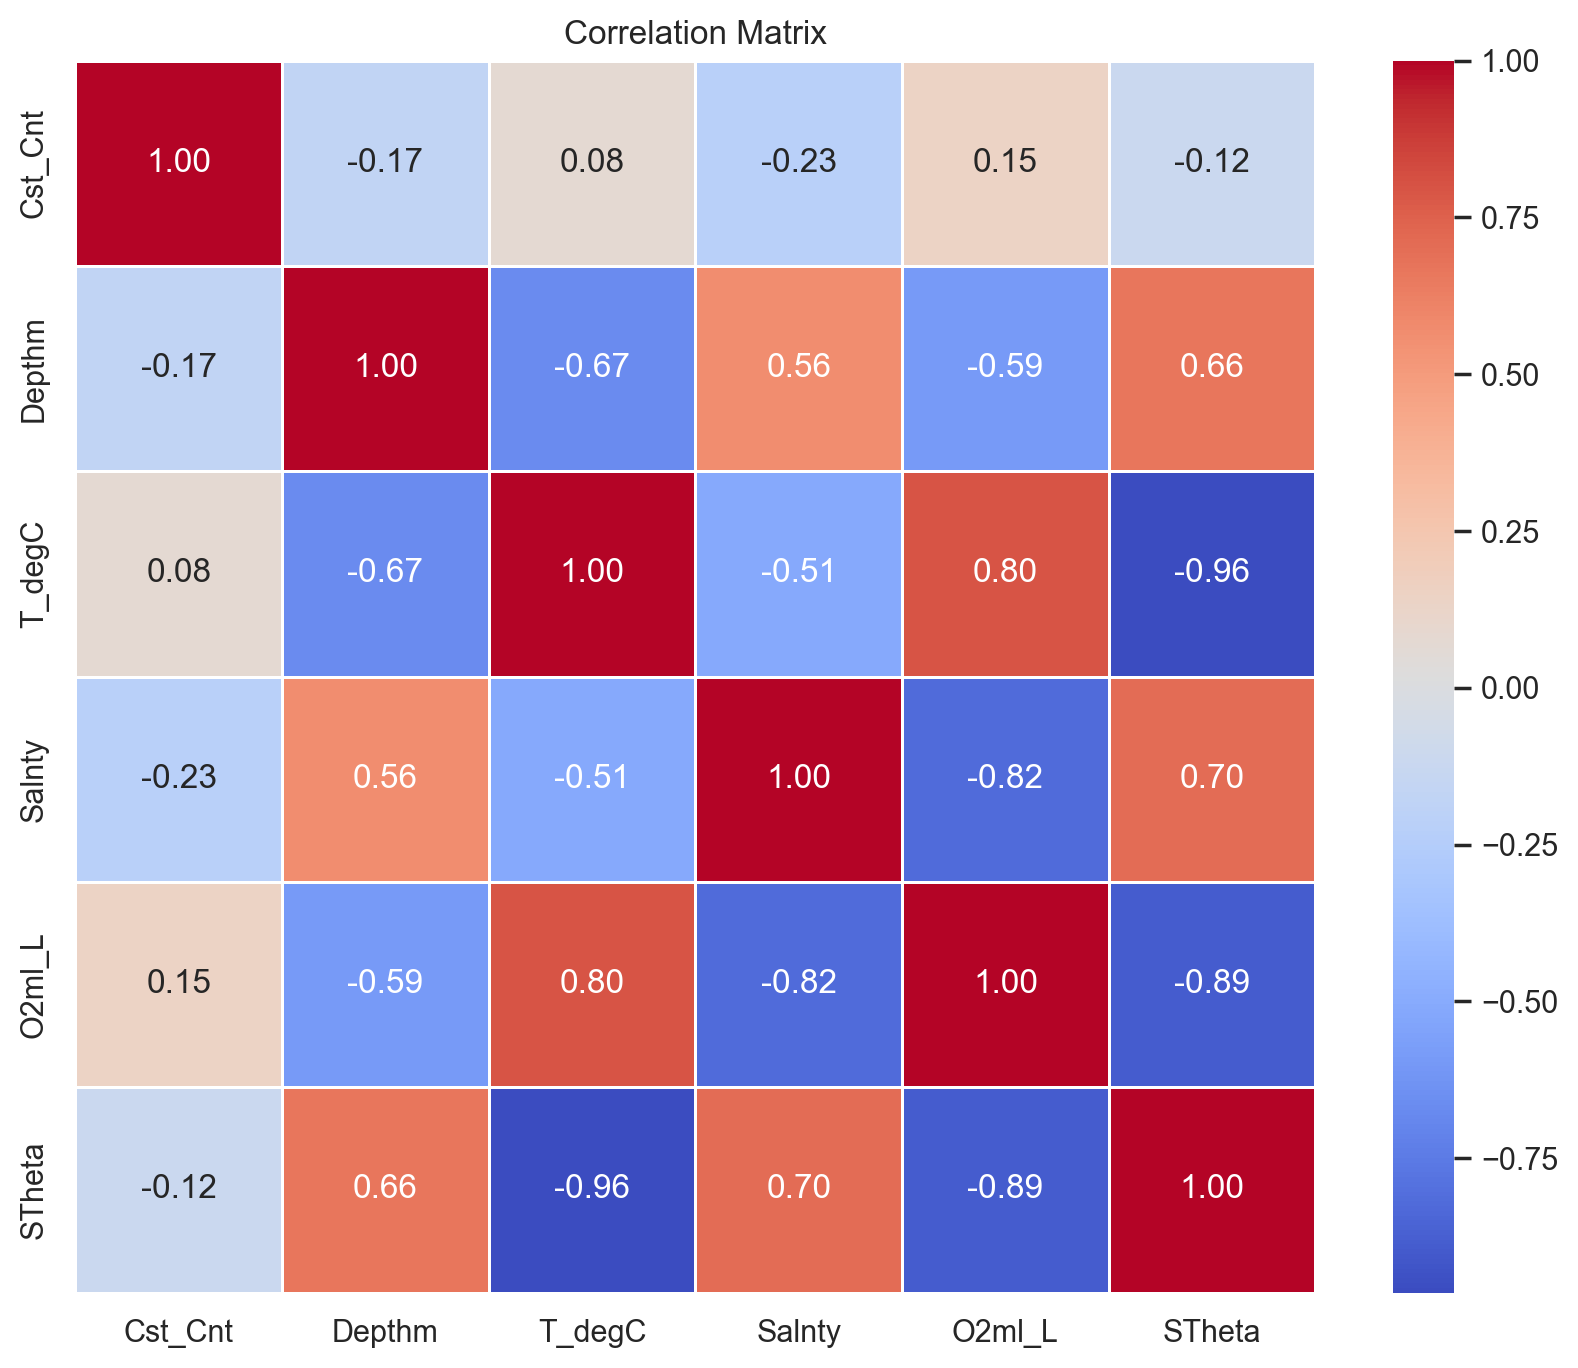

In [17]:
# Calculate the correlation matrix
corr_matrix = bottle_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

#### Correlation Plots

Select from the correlation matrix the 4 features involved in the most correlated pairs and plot their relationship.

<span style="color:red">Implement your solution below</span>

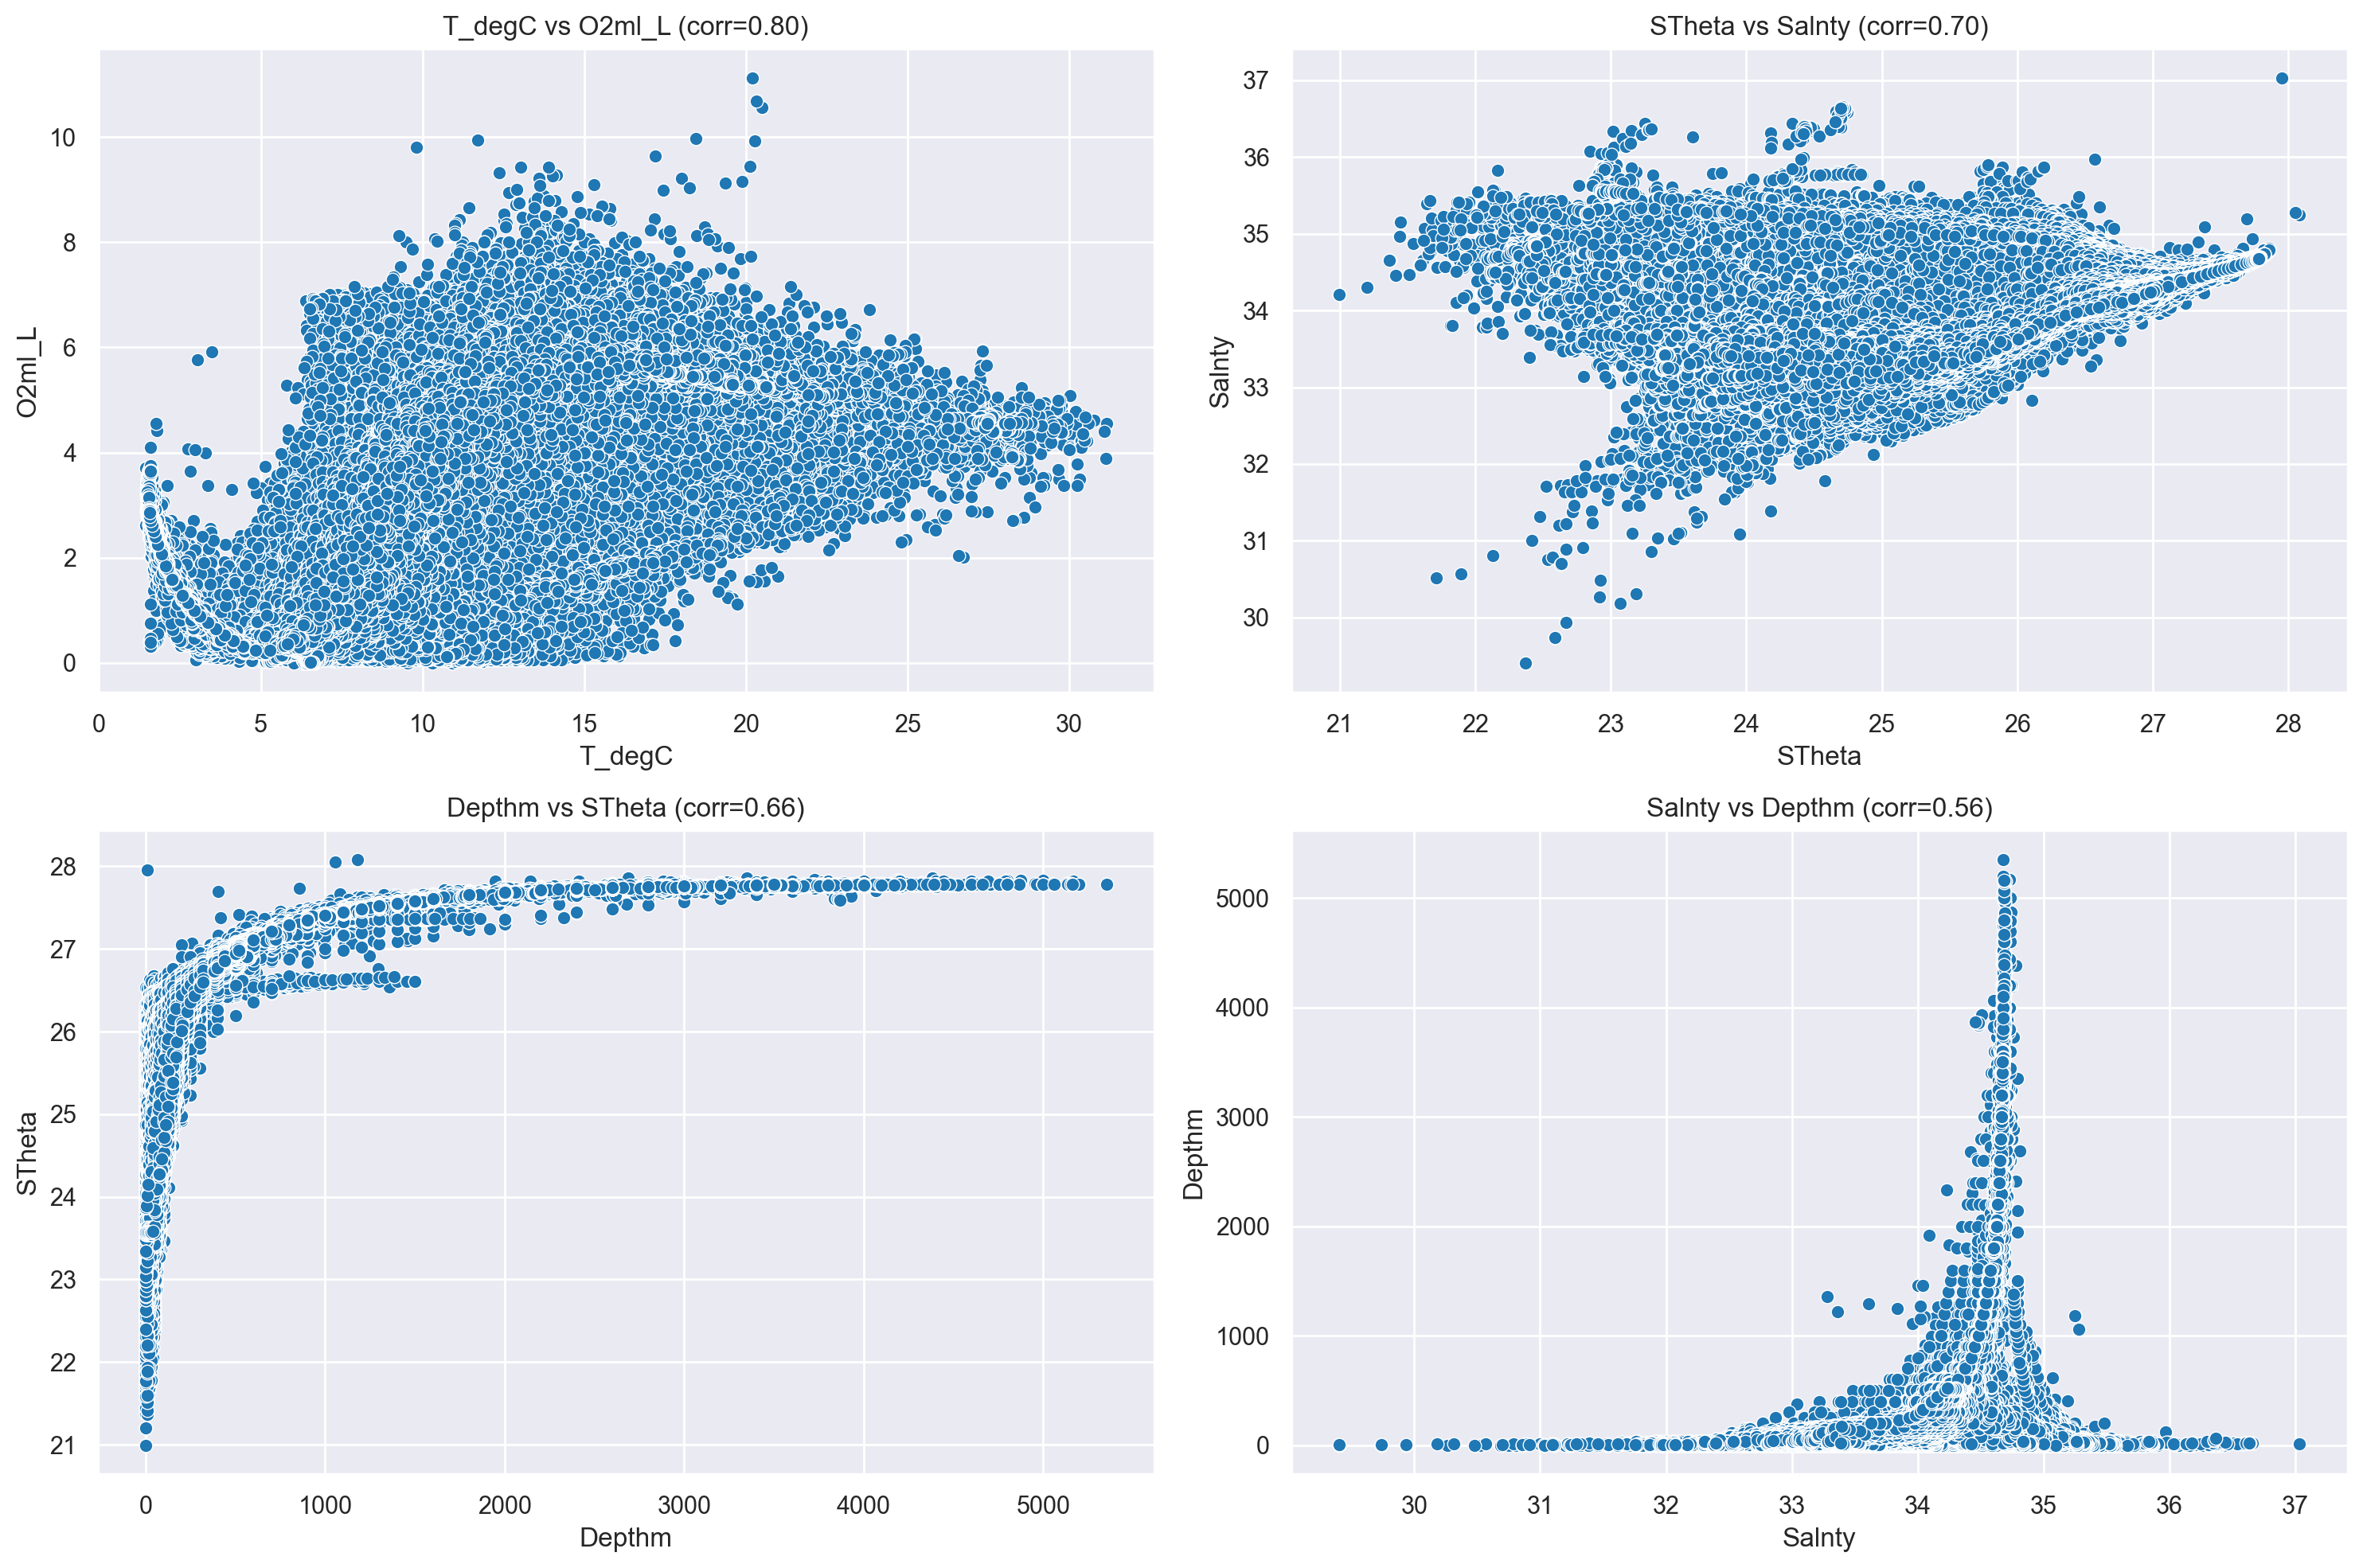

In [19]:
# Select the 4 most correlated pairs from the correlation matrix
corr_pairs = corr_matrix.unstack().sort_values(ascending=False).drop_duplicates()
top_corr_pairs = corr_pairs[1:5]  # Exclude the first pair as it is always (1,1)

# Plot the relationships of the 4 most correlated pairs
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for (i, ((var1, var2), corr)) in enumerate(top_corr_pairs.items()):
    ax = axes[i // 2, i % 2]
    sns.scatterplot(data=bottle_df, x=var1, y=var2, ax=ax)
    ax.set(title=f"{var1} vs {var2} (corr={corr:.2f})")

plt.tight_layout()
plt.show()

#### Depth – Temperature – Salinity

*   The Temperature as a function of the Depth

*   The Salinity as a function of the Depth

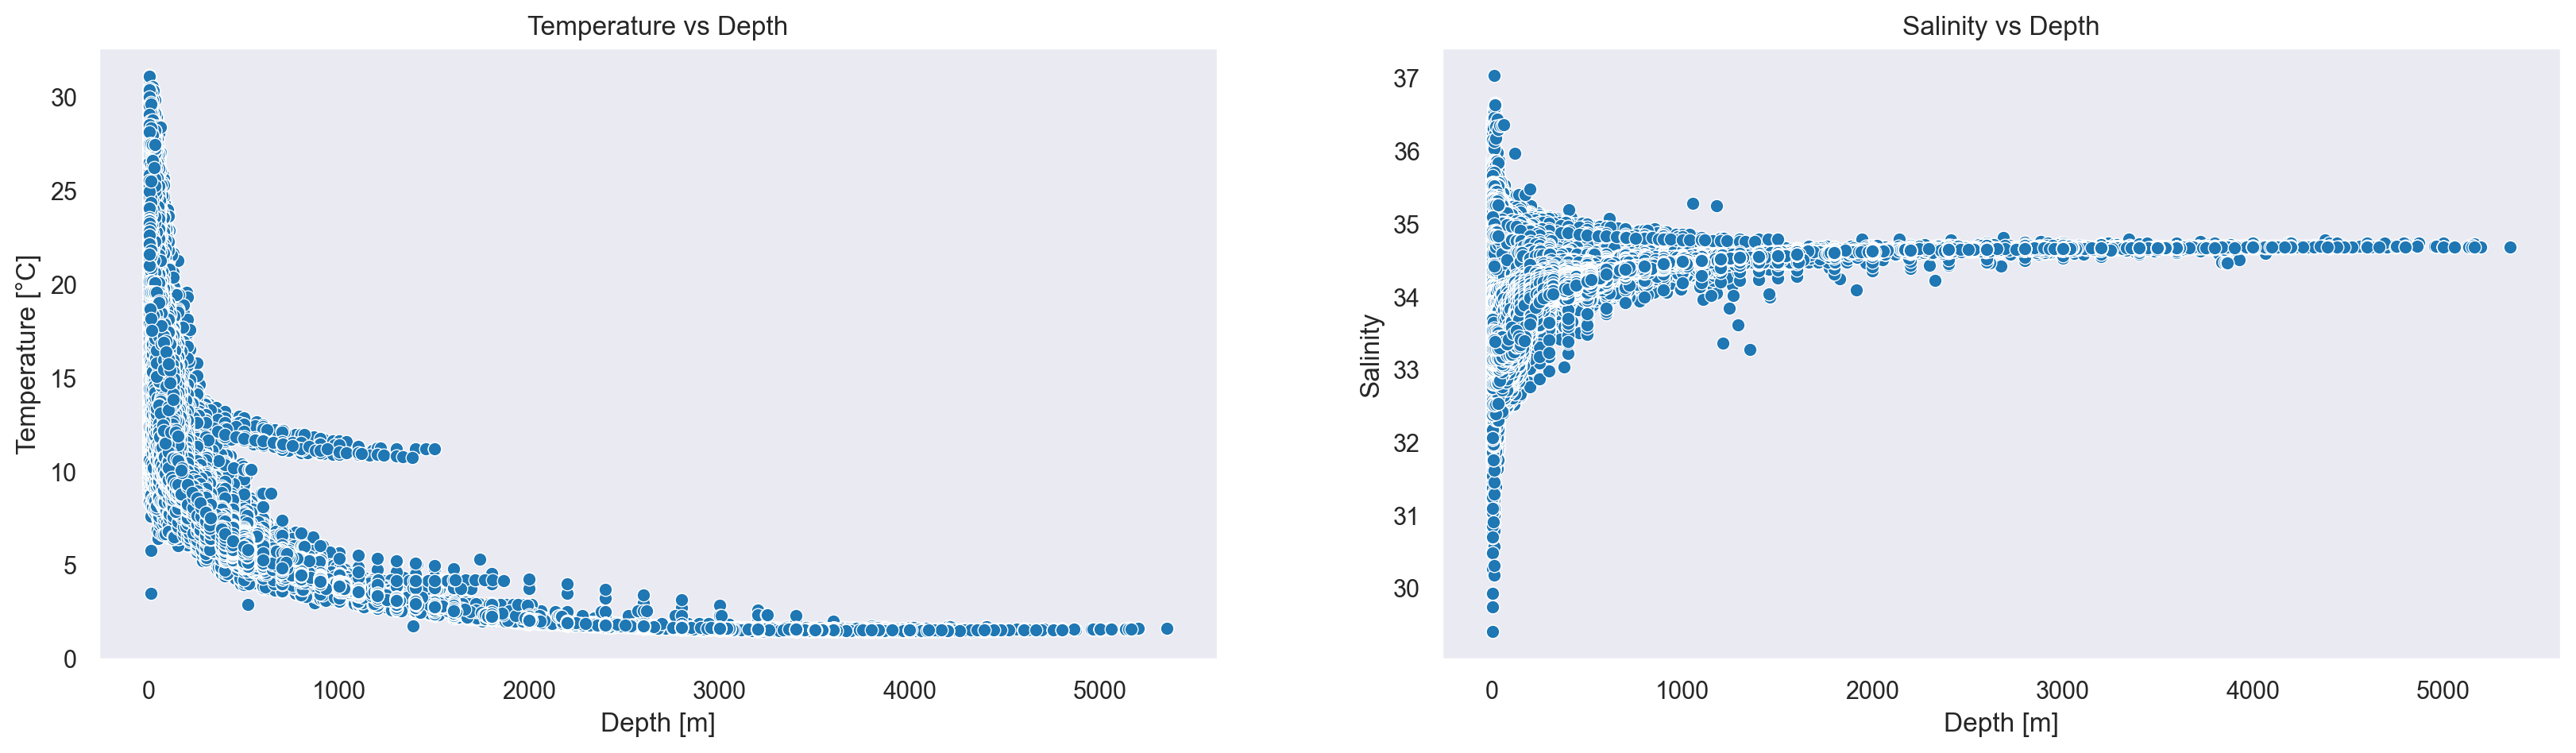

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
g1 = sns.scatterplot(data=bottle_df, x="Depthm", y="T_degC", ax=ax[0])
ax[0].set(
    xlabel="Depth [m]",
    ylabel="Temperature [°C]",
    title="Temperature vs Depth",
)
ax[0].grid()
g2 = sns.scatterplot(data=bottle_df, x="Depthm", y="Salnty", ax=ax[1])
ax[1].set(xlabel="Depth [m]", ylabel="Salinity", title="Salinity vs Depth")
ax[1].grid()

As we can see from the image above, temperature and salinity trace a hyperbolic trend as depth changes:

- In the first plot, some points in the upper part of the image show a different trend from the rest of the graph. It is an unexpected behavior because, for instance, at around 1000 m depth, the expected temperature is around 5°C, but we also find temperatures between 10°C and 15°C (https://www.windows2universe.org/earth/Water/temp.html).

- In the second plot, the points converge asymptotically from both high and low salinity values. It means salinity increases with depth in some ocean areas and vice versa.

Suppose we isolate data points with salinity values in the range above the salinity values in the deepest ocean area. In that case, we observe an alternative trend highlighted in the Temperature-Depth graph.

In [21]:
max_depth_salnty = bottle_df.loc[bottle_df.Depthm.idxmax()].Salnty
max_depth_salnty += 0.1  # Margin to stay on the upper side of the asymptote
pprint_var(max_depth_salnty=max_depth_salnty)

bottle_hi_salt_df = bottle_df[bottle_df.Salnty > max_depth_salnty]
bottle_hi_salt_df   # with max_depth_salnty = 34.85: 6818 rows × 6 columns

max_depth_salnty = 34.78


,Cst_Cnt,Depthm,T_degC,Salnty,O2ml_L,STheta
6775,305,1180,3.10,35.250,0.49,28.083
35149,1303,854,4.01,34.930,1.85,27.736
36248,1339,415,7.80,35.090,0.28,27.381
49703,1809,2142,1.98,34.790,1.85,27.817
49708,1809,2688,1.73,34.810,2.47,27.855
...,...,...,...,...,...,...
331402,19189,11,27.49,34.839,4.62,22.442
331403,19189,20,27.47,34.838,4.59,22.449
331404,19189,30,27.45,34.837,4.55,22.455
331405,19189,31,27.45,34.837,4.55,22.455


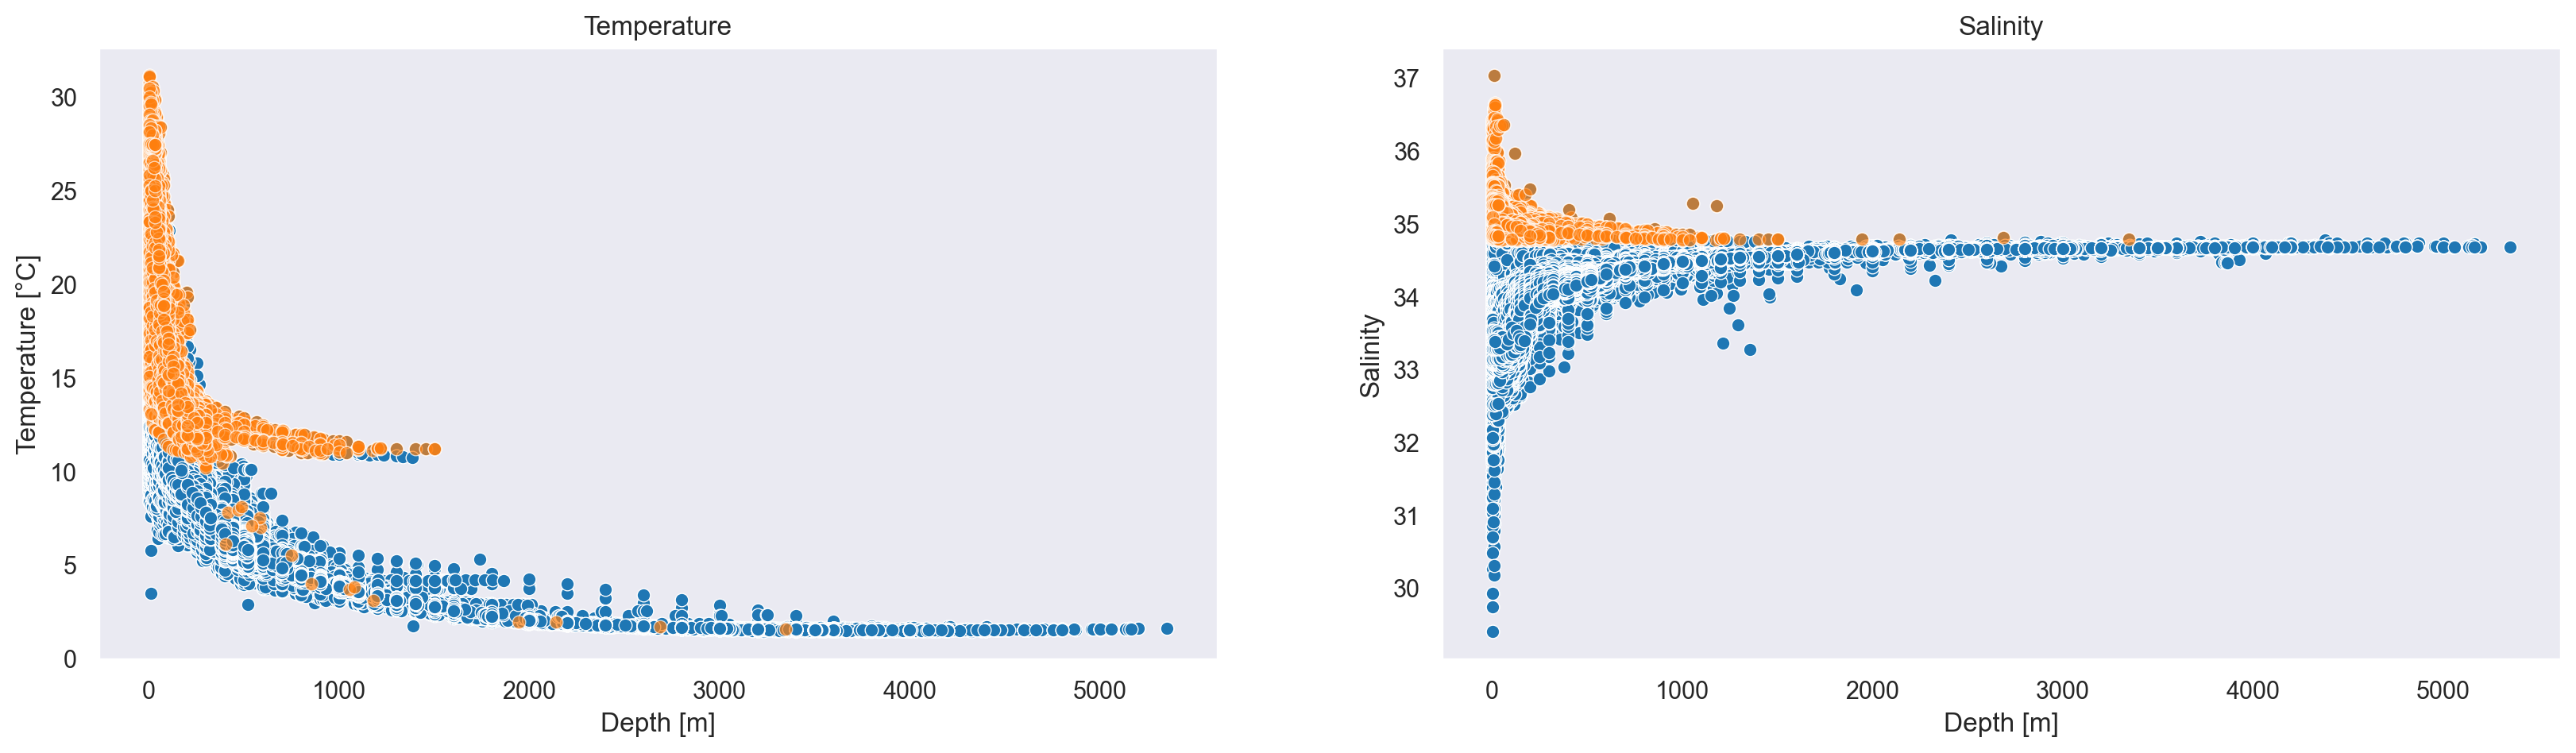

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
g1 = sns.scatterplot(data=bottle_df, x="Depthm", y="T_degC", ax=ax[0])
g1 = sns.scatterplot(
    bottle_hi_salt_df,
    x="Depthm",
    y="T_degC",
    ax=ax[0],
    alpha=0.7,
)
ax[0].set(xlabel="Depth [m]", ylabel="Temperature [°C]", title="Temperature")
ax[0].grid()
g2 = sns.scatterplot(data=bottle_df, x="Depthm", y="Salnty", ax=ax[1])
g2 = sns.scatterplot(
    data=bottle_hi_salt_df, x="Depthm", y="Salnty", ax=ax[1], alpha=0.7
)
ax[1].set(xlabel="Depth [m]", ylabel="Salinity", title="Salinity")
ax[1].grid()

### Predictive Models

#### Splitting the Dataset

<span style="color:red">Implement your solution below</span>

In [23]:
# Split the dataset into training and testing sets
X = bottle_df[['Depthm']]  # Features
y = bottle_df['T_degC']    # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Training set size: 529014
Testing set size: 132254


#### Linear Regression

*   Try predicting the temperature based on depth only.

*   Evaluate the model using the RMSE and the R2 score.

*   Plot the test data and the predicted line.

<span style="color:red">Implement your solution below</span>

RMSE: 3.1491
R2 Score: 0.4433


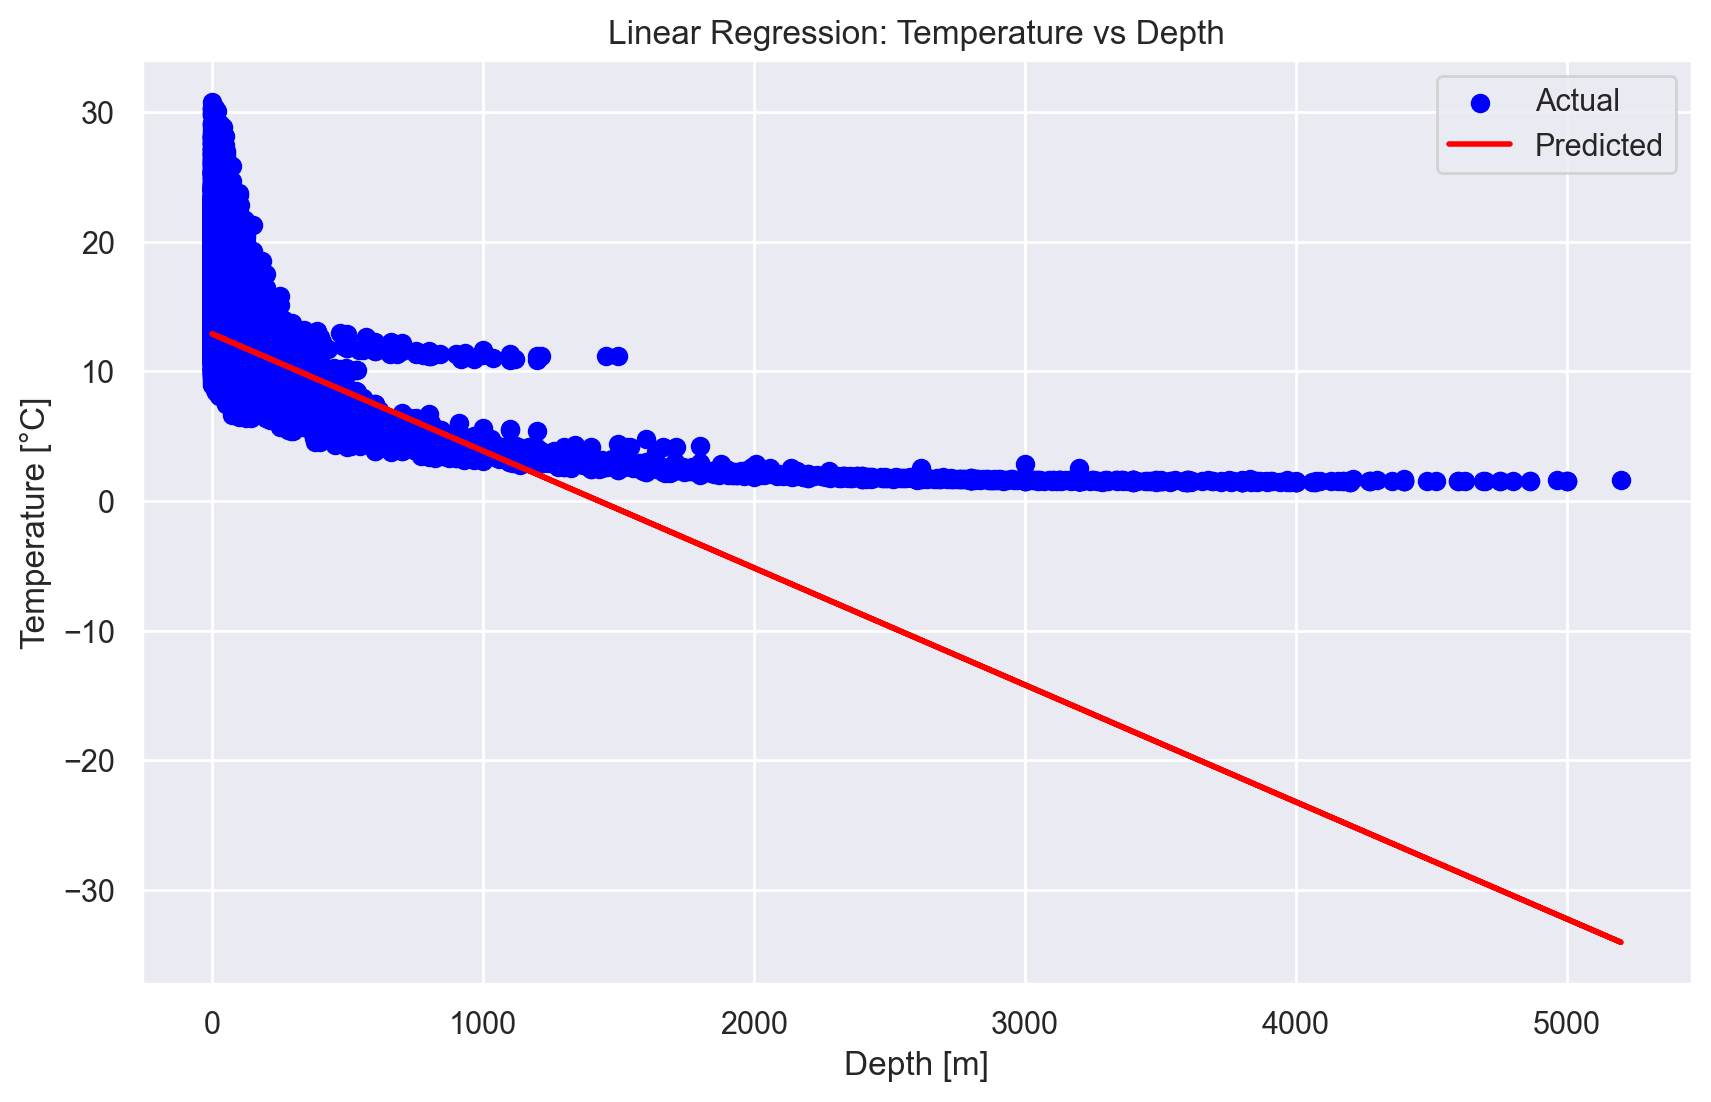

In [24]:
# Initialize the Linear Regression model
linear_reg_model = LinearRegression()

# Train the model
linear_reg_model.fit(X_train, y_train)

# Predict the temperature for the test set
y_pred = linear_reg_model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
r2 = metrics.r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")

# Plot the test data and the predicted line
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Predicted')
plt.xlabel('Depth [m]')
plt.ylabel('Temperature [°C]')
plt.title('Linear Regression: Temperature vs Depth')
plt.legend()
plt.show()

### Polynomial Regression

*   Adapt linear regression by transforming data according to basis functions

*   E.g., with a polynomial projection:
    $$\hat{y} = a_0 + a_1 x + a_2 x^2 + \cdots + a_n x^n$$

*   Note that this is still a linear model

    *   It is linear in the sense that we never multiply or divide the coefficients

    *   The one-dimensional descriptor $x$ is projected in one or more dimensions to allow modeling more complex relations between $x$ and $y$

*   Try predicting the temperature based on depth only using a polynomial regression (e.g., until `degree=5`).

*   Evaluate the model using the RMSE and the R2 score.

*   Plot the test data and the predicted curve.

<span style="color:red">Implement your solution below</span>

Polynomial Regression (degree=5) RMSE: 2.1007
Polynomial Regression (degree=5) R2 Score: 0.7523


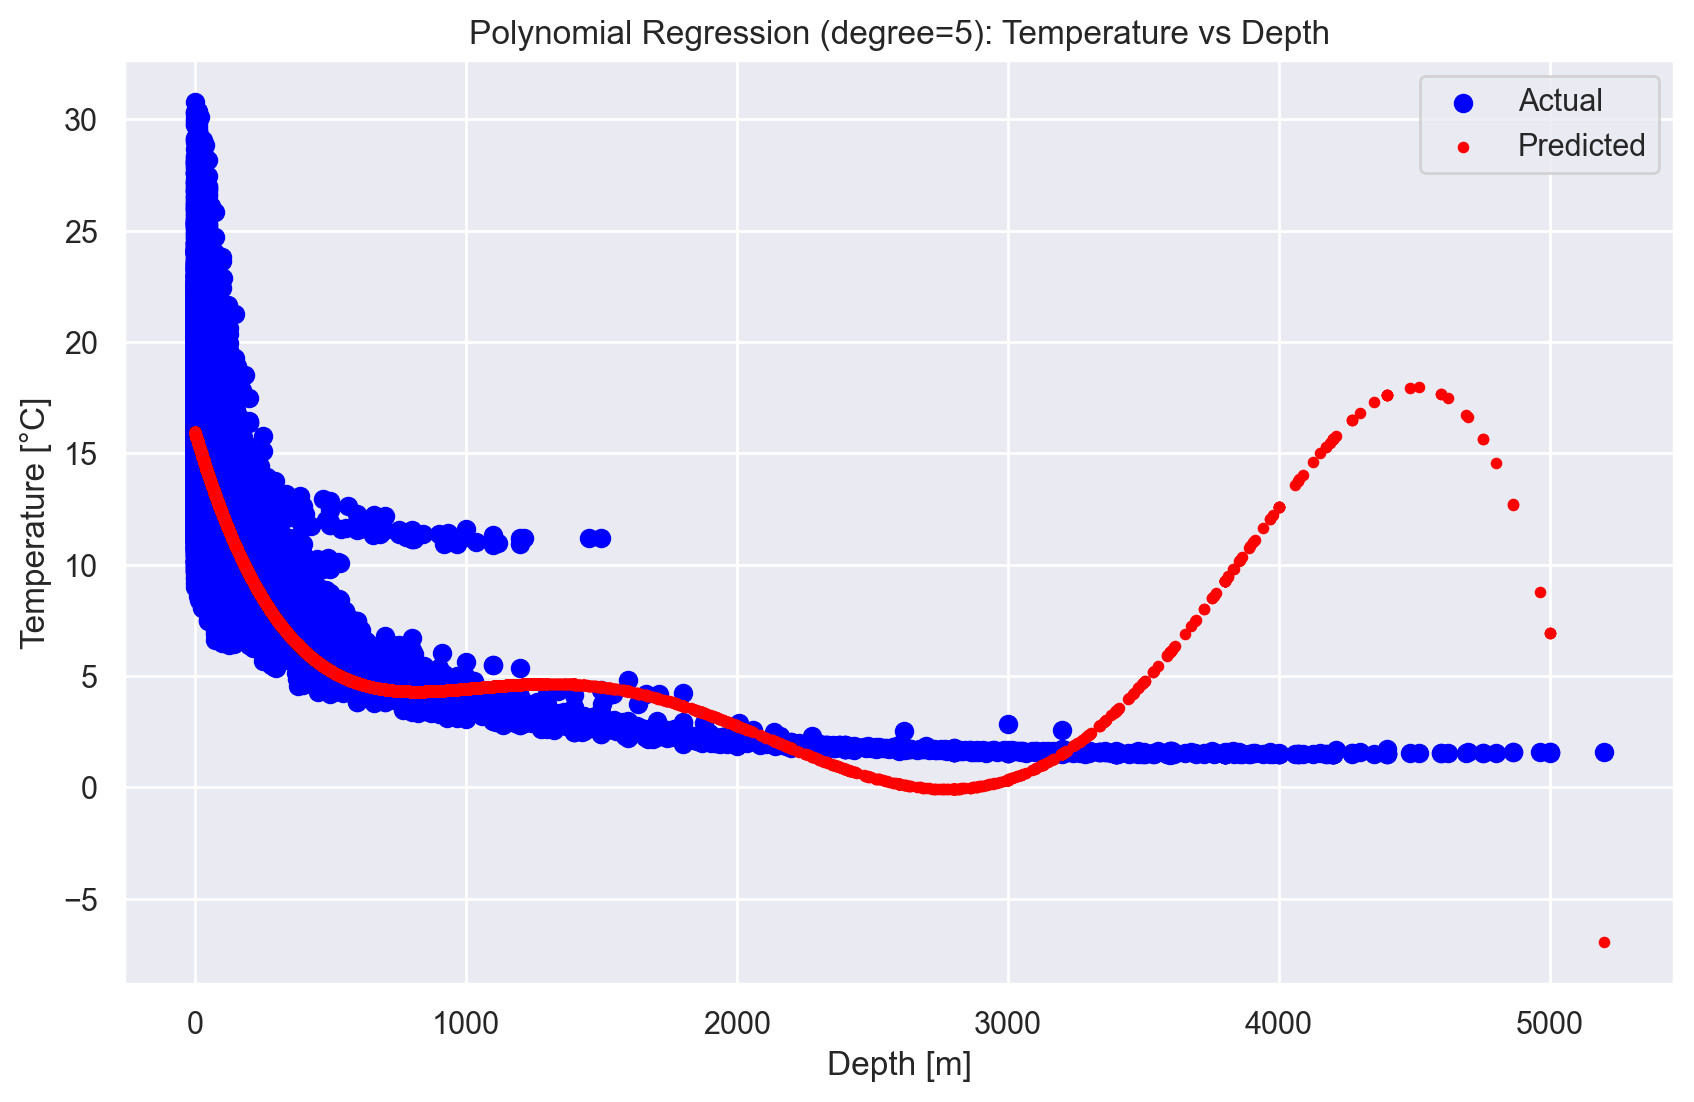

In [25]:
from sklearn.preprocessing import PolynomialFeatures

# Transform the data for polynomial regression
degree = 5
poly = PolynomialFeatures(degree)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

# Initialize the Linear Regression model
poly_reg_model = LinearRegression()

# Train the model
poly_reg_model.fit(X_poly_train, y_train)

# Predict the temperature for the test set
y_poly_pred = poly_reg_model.predict(X_poly_test)

# Evaluate the model
poly_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_poly_pred))
poly_r2 = metrics.r2_score(y_test, y_poly_pred)

print(f"Polynomial Regression (degree={degree}) RMSE: {poly_rmse:.4f}")
print(f"Polynomial Regression (degree={degree}) R2 Score: {poly_r2:.4f}")

# Plot the test data and the predicted curve
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.scatter(X_test, y_poly_pred, color='red', s=10, label='Predicted')
plt.xlabel('Depth [m]')
plt.ylabel('Temperature [°C]')
plt.title(f'Polynomial Regression (degree={degree}): Temperature vs Depth')
plt.legend()
plt.show()

#### Multiple Linear Regression

*   Perform the linear regression again using the set of 5 features available instead of just one.

*   Evaluate the performance of the regression in terms of MSE and $R^2$.

*   Identify the features that seem the most significant for this regression, by observing the value of their respective parameter ($a_j$ via `model.coef_`).

*   Comment succinctly.

<span style="color:red">Implement your solution below</span>

In [26]:
# Perform linear regression using the set of 5 features available
X_multi = bottle_df[['Depthm', 'Salnty', 'O2ml_L', 'STheta', 'Cst_Cnt']]
y_multi = bottle_df['T_degC']

# Split the dataset into training and testing sets
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X_multi, y_multi, test_size=0.2, random_state=42)

# Initialize the Linear Regression model
multi_reg_model = LinearRegression()

# Train the model
multi_reg_model.fit(X_train_multi, y_train_multi)

# Predict the temperature for the test set
y_pred_multi = multi_reg_model.predict(X_test_multi)

# Evaluate the model
multi_rmse = np.sqrt(metrics.mean_squared_error(y_test_multi, y_pred_multi))
multi_r2 = metrics.r2_score(y_test_multi, y_pred_multi)

print(f"Multiple Linear Regression RMSE: {multi_rmse:.4f}")
print(f"Multiple Linear Regression R2 Score: {multi_r2:.4f}")

# Identify the features that seem the most significant
coefficients = pd.DataFrame(multi_reg_model.coef_, X_multi.columns, columns=['Coefficient'])
print(coefficients)

# Comment: The features with the highest absolute values of coefficients are the most significant for this regression.

Multiple Linear Regression RMSE: 0.3330
Multiple Linear Regression R2 Score: 0.9938
         Coefficient
Depthm     -0.001520
Salnty      3.549199
O2ml_L      0.146486
STheta     -4.589860
Cst_Cnt     0.000001


### Standardization and PCA

Apply standardization and PCA to the dataset and repeat the regression and the evaluations.

The goal is to see if the performance of the regression improves and if the features that are the most significant change.

Try to analyze the results and comment on your observations (possibly with tables and plots similar to those in the PCA notebook).

<span style="color:red">Implement your solution below</span>

PCA Regression RMSE: 0.3330
PCA Regression R2 Score: 0.9938


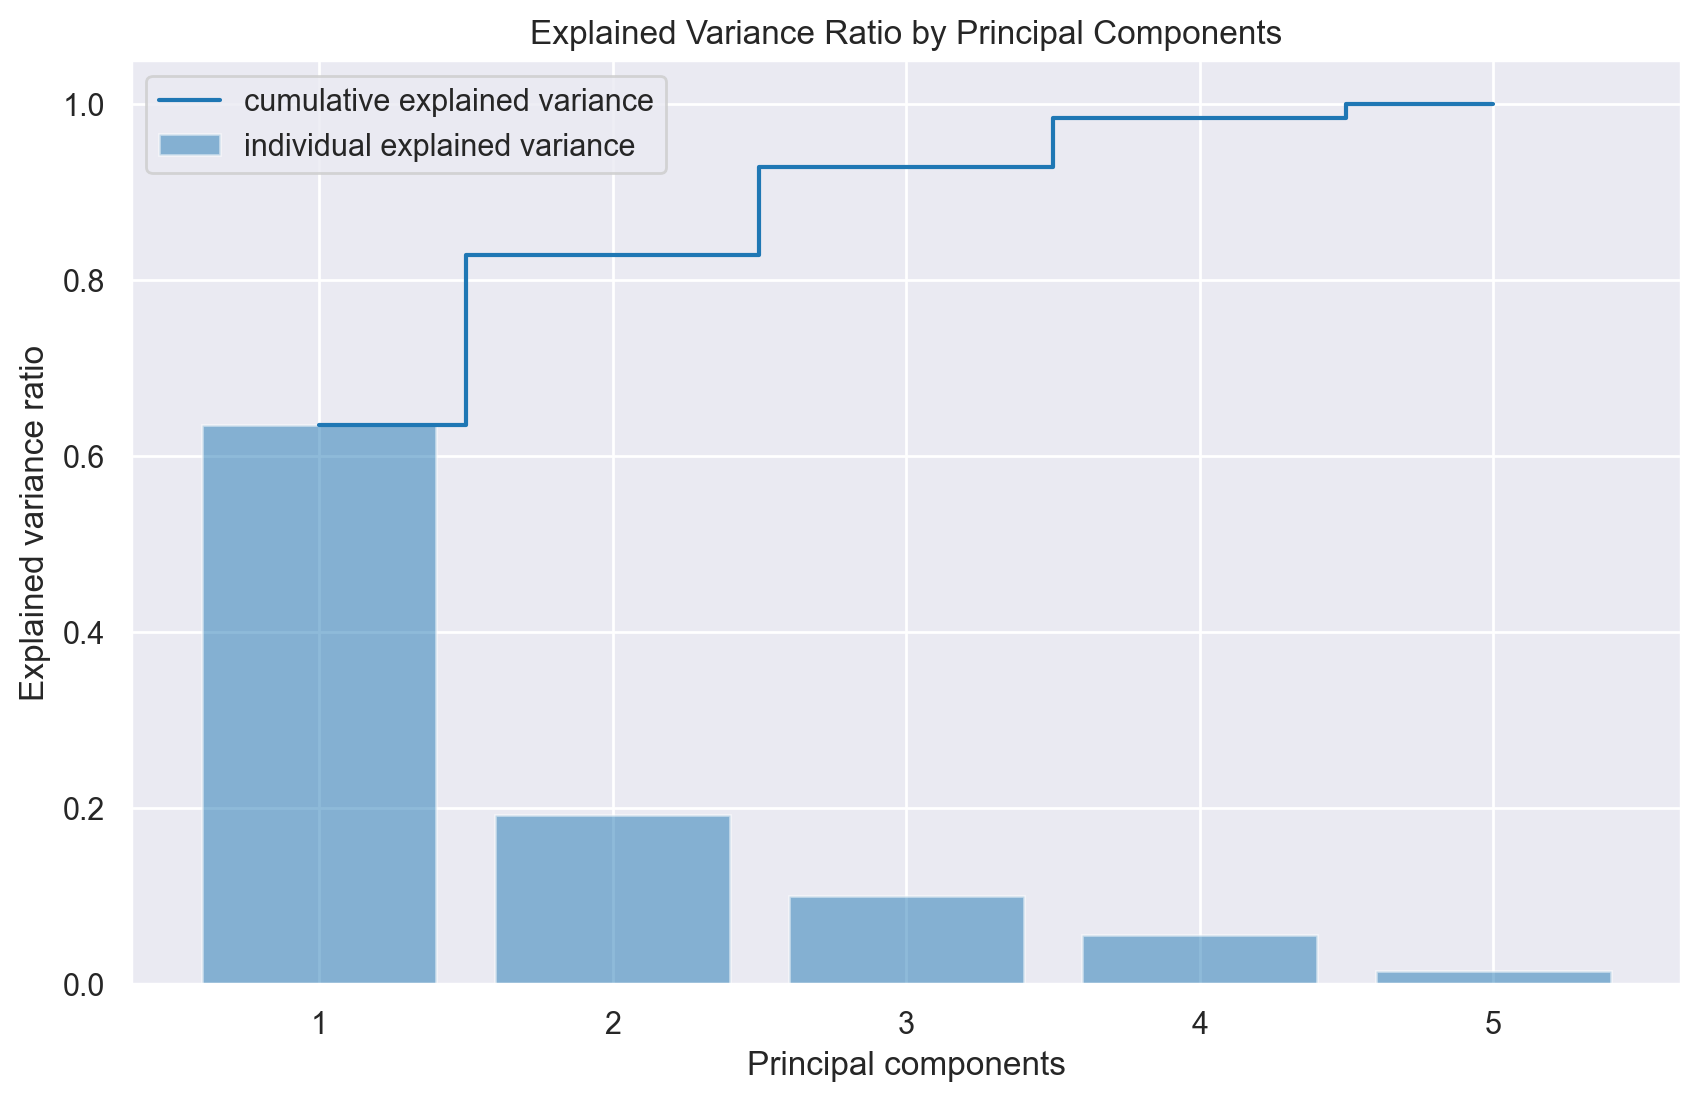

   Coefficient
0     1.950313
1    -0.782388
2    -0.744509
3     3.991245
4    -1.886389


In [27]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the dataset
scaler = StandardScaler()
X_multi_scaled = scaler.fit_transform(X_multi)

# Apply PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_multi_scaled)

# Split the dataset into training and testing sets
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_multi, test_size=0.2, random_state=42)

# Initialize the Linear Regression model
pca_reg_model = LinearRegression()

# Train the model
pca_reg_model.fit(X_train_pca, y_train_pca)

# Predict the temperature for the test set
y_pred_pca = pca_reg_model.predict(X_test_pca)

# Evaluate the model
pca_rmse = np.sqrt(metrics.mean_squared_error(y_test_pca, y_pred_pca))
pca_r2 = metrics.r2_score(y_test_pca, y_pred_pca)

print(f"PCA Regression RMSE: {pca_rmse:.4f}")
print(f"PCA Regression R2 Score: {pca_r2:.4f}")

# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.bar(range(1, 6), pca.explained_variance_ratio_, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1, 6), np.cumsum(pca.explained_variance_ratio_), where='mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.title('Explained Variance Ratio by Principal Components')
plt.show()

# Comment on the results
coefficients_pca = pd.DataFrame(pca_reg_model.coef_, columns=['Coefficient'])
print(coefficients_pca)

# Comment: The features with the highest absolute values of coefficients are the most significant for this regression.
# The PCA transformation may change the significance of the features as it combines them into principal components.

---